In [2]:
%matplotlib notebook
from arc import *
from basics import *
import numpy as np
import matplotlib.pyplot as plt
#from numpy import *

In [3]:
class RydStateFS:
    """
    Tiny wrapper class to hold quantum numbers of rydberg state in FS basis
    
    """
    def __init__(self, n, l, j,**kwargs):
        """
        Args:
            n : principle quantum number (int)
            l : orbital angular momentum quantum number (int)
            j : FS angular momentum quantum number (int/half int)
        kwargs:
            for additional desired quantum numbers
        """
        self.n = n
        self.l = l
        self.j = j
        self.__qn = {"n": n, "l": l, "j": j}
        self.__qn.update(kwargs)
        if "atom" in kwargs.keys():
            self.atom_name = kwargs["atom"]
        else:
            self.atom_name = "Cesium"
        self.atom = eval(f"{self.atom_name}()")
    def __getitem__(self,arg):
        return self.__qn[arg]
    def quantum_numbers(self):
        return self.__qn
    def get_energy(self):
        return self.atom.getEnergy(self.n,self.l,self.j)
    def __repr__(self):
        return f"RydStateFS({','.join([f'{key}={value}' for key,value in self.__qn.items()])})"
    def ket(self):
        L_labels = {0: "S", 1: "P", 2: "D",3:"F"}
        return f"|{self.n},{L_labels[self.l]},{int(2*self.j)}/2>"


def detuning(state1: RydStateFS, state2: RydStateFS, field_nu: float):
    """
    Returns detuning of field from bare resonance between state1 and state2
    Args:
        state1: Rydberg state in FS basis for the first state
        state2: Rydberg state in FS basis for the second state
        field_nu: radial frequency of a single tone field coupling state1 and state2 (Hz)
    Returns:
        detuning : field detuning from bare resonance in Hz (radial frequency)
    """
    bare_res = (state1.get_energy()-state2.get_energy())*e/h
    return bare_res - field_nu
def states_sgn(state1: RydStateFS, state2: RydStateFS):
    return -np.sign(state1.get_energy()-state2.get_energy())

tau = 2*pi

<IPython.core.display.Javascript object>


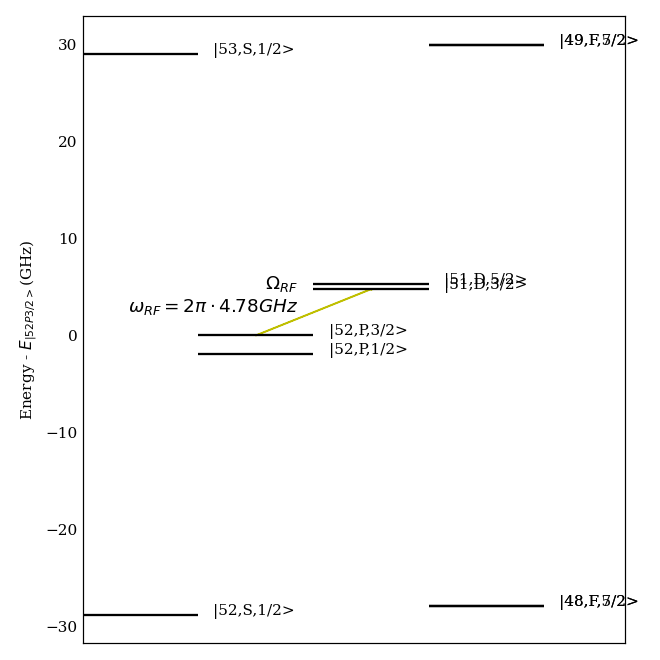

In [4]:
states = [
    RydStateFS(52,1,3/2),
    RydStateFS(52,1,1/2),
    RydStateFS(51,2,3/2),
    RydStateFS(51,2,5/2),
#    RydStateFS(50,2,3/2),
#    RydStateFS(50,2,5/2),
#    RydStateFS(50,3,5/2),
#    RydStateFS(50,3,7/2),
    RydStateFS(49,3,5/2),
    RydStateFS(49,3,7/2),
    RydStateFS(48,3,5/2),
    RydStateFS(48,3,7/2),
    RydStateFS(52,0,1/2),
    RydStateFS(53,0,1/2),
#    RydStateFS(52,2,3/2),
#    RydStateFS(52,2,5/2),
#    RydStateFS(50,2,3/2),
#    RydStateFS(50,2,5/2)
]
t_state = RydStateFS(52,1,3/2)
e_state = RydStateFS(51,1,3/2)
field_nu = 4.780# + 0.050 + 0.250  #GHz

energies = [detuning(state,t_state,0)*1e-9 for state in states]
fig, ax = plt.subplots(1,1,figsize=(6,6))
for state, energy in zip(states, energies):
    spacing=1
    ax.hlines([energy],state.l*spacing,(state.l+1)*spacing, label=state.ket(),colors='k')
    ax.annotate(state.ket(), ((state.l+1)*spacing, energy), textcoords="offset points", xytext=(10,0),ha='left')
# add an arrow    
ax.arrow((t_state.l+1/2)*spacing,0,spacing, field_nu,length_includes_head=True, shape='full',width=0.01, head_width=0.05,color='y')
#ax.arrow((t_state.l+1/2)*spacing,-detuning(t_state,RydStateFS(52,1,1/2),0)*1e-9,spacing, field_nu,length_includes_head=True, shape='full',width=0.01, head_width=0.05,color='y')
ax.annotate(f"$\Omega_{{RF}}$\n$\omega_{{RF}}=2\pi \cdot {field_nu} GHz$", ((t_state.l+1)*spacing,field_nu/2), textcoords="offset points", xytext=(-10,0),ha="right",fontweight="heavy",fontsize="large")
ax.set_ylabel("Energy - $E_{|52P3/2>}$(GHz)")
ax.set_xlim(0,(max([state.l for state in states])+1.7)*spacing)
ax.tick_params(which="both",bottom=False,top=False,left=False,right=False,labelbottom=False)
fig.tight_layout()
fig.show()
fig.savefig("RF Grotrian-PsandDs.png")

In [16]:
ryd1 = RydStateFS(53,0,1/2)
ryd2 = RydStateFS(49,3,5/2)
ryd3 = RydStateFS(52,1,3/2)
field_freq_for_esimate = 0*4.780e9 # np.linspace(4.68e9,4.78e9,100)
# print(detuning(ryd1,ryd2, field_freq)*1e-6)
detuning(ryd1,ryd2,0)*1e-6

-904.0687221840016

In [4]:
print(states_sgn(ryd1,ryd2))

1.0


In [5]:
target_state = ryd1
considered_states = [
    RydStateFS(52,0,1/2),
    RydStateFS(53,0,1/2),
    RydStateFS(50,2,3/2),
    RydStateFS(50,2,5/2),
    RydStateFS(51,2,3/2),
    RydStateFS(51,2,5/2),
    RydStateFS(52,2,3/2),
    RydStateFS(52,2,5/2)
]
detunings = {f"{state}": detuning(target_state,state,field_freq_for_esimate) for state in considered_states}
dipoles = {f"{state}": target_state.atom.getReducedMatrixElementJ(
    ryd1.n,
    ryd1.l,
    ryd1.j,
    state.n,
    state.l,
    state.j
)*e*ao for state in considered_states}

signs = {f"{state}": states_sgn(target_state,state) for state in considered_states}

AC_sum = sum([-signs[f"{state}"]*dipoles[f"{state}"]**2/(4*detunings[f"{state}"]) for state in considered_states])

In [6]:
d_AC = -3e6*tau  # Measured AC stark shift at given frequency; -6 MHz as measured
e_field_estimate_sq = hb**2 * d_AC/ AC_sum
print(f"Estimated $E^2$ = {e_field_estimate_sq} $V^2/m^2$")

Estimated $E^2$ = 1.1253546611058973 $V^2/m^2$


In [7]:
(sqrt(e_field_estimate_sq)*Cesium().getReducedMatrixElementJ(52,1,3/2,51,2,5/2)*e*ao/hb)/tau*1e-6

-73.59407244343964

In [8]:
ryd1 = RydStateFS(52,1,3/2)
ryd2 = RydStateFS(51,2,3/2)
field_freqs = np.linspace(4.68e9,5.4e9,10000)*tau
print(detuning(ryd1,ryd2, field_freqs)/tau*1e-6)

[ 150.55779721  150.48579001  150.41378281 ... -569.29818838 -569.37019559
 -569.44220279]


In [9]:
target_state = ryd1
considered_states = [
    RydStateFS(52,0,1/2),
    RydStateFS(53,0,1/2),
    RydStateFS(50,2,3/2),
    RydStateFS(50,2,5/2),
    RydStateFS(51,2,3/2),
    RydStateFS(51,2,5/2),
    RydStateFS(52,2,3/2),
    RydStateFS(52,2,5/2)
]
# considered_states = [RydStateFS(51,2,3/2)]
detunings = {f"{state}": detuning(target_state,state,field_freqs) for state in considered_states}
dipoles = {f"{state}": target_state.atom.getReducedMatrixElementJ(
    ryd1.n,
    ryd1.l,
    ryd1.j,
    state.n,
    state.l,
    state.j
)*e*ao for state in considered_states}

signs = {f"{state}": states_sgn(target_state,state) for state in considered_states}

AC_sum = sum([-signs[f"{state}"]*dipoles[f"{state}"]**2/(4*detunings[f"{state}"]) for state in considered_states])

In [10]:
print(AC_sum)

[-1.86279051e-61 -1.86322044e-61 -1.86365068e-61 ...  1.96473792e-60
  1.96149092e-60  1.95825470e-60]


<IPython.core.display.Javascript object>


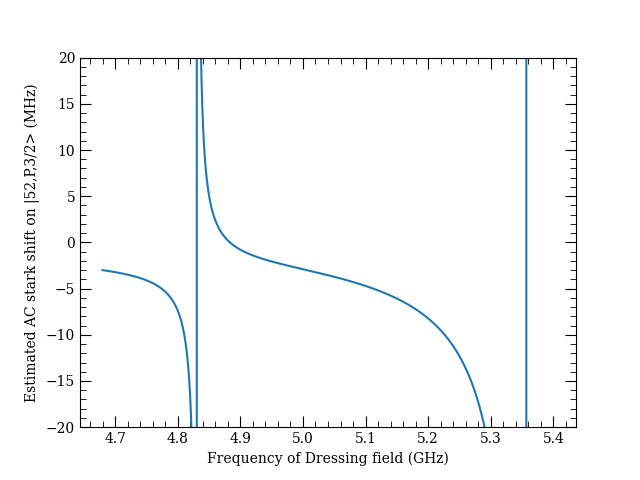

In [11]:
AC_stark_shifts = e_field_estimate_sq/hb**2 * AC_sum
fig,ax = plt.subplots(1,1)
ax.plot(field_freqs*1e-9/tau,AC_stark_shifts*1e-6/tau)
ax.set_ylabel(f"Estimated AC stark shift on {ryd1.ket()} (MHz)")
ax.set_xlabel(f"Frequency of Dressing field (GHz)")
ax.set_ylim(-20,20)
fig.show()

In [22]:
E_s = (5.4e9/(ryd1.atom.getReducedMatrixElementJ(ryd1.n,ryd1.l,ryd1.j,51,2,5/2)*e*ao/h))**2
print(10*np.log10(E_s/4))

31.80331270483828


In [30]:
quad_states = [
    RydStateFS(45,3,5/2),
    RydStateFS(46,3,5/2),
    RydStateFS(47,3,5/2),
    RydStateFS(48,3,5/2),
    RydStateFS(49,3,5/2),
    RydStateFS(50,3,5/2),
    RydStateFS(51,3,5/2),
]
print("\n".join(
    [f"detuning between {target_state.ket()} and {state.ket()} = {states_sgn(target_state,state)*detuning(target_state,state,0)*1e-9/tau}GHz" for state in quad_states]
))

detuning between |52,P,3/2> and |45,F,5/2> = -225.01064121393296GHz
detuning between |52,P,3/2> and |46,F,5/2> = -154.9899045607284GHz
detuning between |52,P,3/2> and |47,F,5/2> = -89.39392348124412GHz
detuning between |52,P,3/2> and |48,F,5/2> = -27.85759085827803GHz
detuning between |52,P,3/2> and |49,F,5/2> = 29.947304657218915GHz
detuning between |52,P,3/2> and |50,F,5/2> = 84.31646402806241GHz
detuning between |52,P,3/2> and |51,F,5/2> = 135.51686693366966GHz


In [12]:
help(Cesium().getQuadrupoleMatrixElement)

Help on method getQuadrupoleMatrixElement in module arc.alkali_atom_functions:

getQuadrupoleMatrixElement(n1, l1, j1, n2, l2, j2, s=0.5) method of arc.alkali_atom_data.Cesium instance
    Radial part of the quadrupole matrix element
    
    Calculates :math:`\int \mathbf{d}r~R_{n_1,l_1,j_1}(r)\cdot             R_{n_1,l_1,j_1}(r) \cdot r^4`.
    See `Quadrupole calculation example snippet`_  .
    
    .. _`Quadrupole calculation example snippet`:
        ./Rydberg_atoms_a_primer.html#Quadrupole-matrix-elements
    
    Args:
        n1 (int): principal quantum number of state 1
        l1 (int): orbital angular momentum of state 1
        j1 (float): total angular momentum of state 1
        n2 (int): principal quantum number of state 2
        l2 (int): orbital angular momentum of state 2
        j2 (float): total angular momentum of state 2
        s (float): optional, total spin angular momentum of state.
            By default 0.5 for Alkali atoms.
    
    Returns:
        float

In [16]:
e_state = RydStateFS(5,2,5/2)
nb_state = RydStateFS(5,2,3/2)
detuning(e_state,nb_state,0)*1e-9

18381.71727967295

In [19]:
dipoles[RydStateFS(51,2,3/2).__repr__()]*(1.63e2/hb)*1e-9

-23.715881165147998

In [2]:
Cesium().getEnergy(52,1,3/2)*e/h

-1402004231222.4731

In [15]:
ao*e

8.478353551956304e-30

In [3]:
cs = Cesium()
n_t = 52
l_t = 1
j_t = 3/2

n_p = 51
l_p = 2
j_p1 = 5/2
j_p2 = 3/2

def split(n1,l1,j1,n2,l2,j2):
    return (cs.getEnergy(n1,l1,j1) - cs.getEnergy(n2,l2,j2))*e/h*1e-9

print(f"Energy between |{n_t},{l_t},{int(2*j_t)}/2> and |{n_p},{l_p},{int(2*j_p1)}/2>  = {split(n_t,l_t,j_t,n_p,l_p,j_p1):.6f}GHz")
print(f"Energy between |{n_t},{l_t},{int(2*j_t)}/2> and |{n_p},{l_p},{int(2*j_p2)}/2>  = {split(n_t,l_t,j_t,n_p,l_p,j_p2):.6f}GHz")

print(f"FS dipole RME between |{n_t},{l_t},{int(2*j_t)}/2> and |{n_p},{l_p},{int(2*j_p1)}/2> = {cs.getReducedMatrixElementJ(n_t,l_t,j_t,n_p,l_p,j_p1):.6f} a0e")
print(f"FS dipole RME between |{n_t},{l_t},{int(2*j_t)}/2> and |{n_p},{l_p},{int(2*j_p2)}/2> = {cs.getReducedMatrixElementJ(n_t,l_t,j_t,n_p,l_p,j_p2):.6f} a0e")

Energy between |52,1,3/2> and |51,2,5/2>  = -5.356698GHz
Energy between |52,1,3/2> and |51,2,3/2>  = -4.830558GHz
FS dipole RME between |52,1,3/2> and |51,2,5/2> = -5421.789200 a0e
FS dipole RME between |52,1,3/2> and |51,2,3/2> = -1809.740444 a0e


In [7]:
print(f"E|51S1/2>-E|52P3/2> = {split(n_t,l_t,j_t,51,0,1/2)}GHz")
print(f"E|52S1/2>-E|52P3/2> = {split(n_t,l_t,j_t,52,0,1/2)}GHz")
print(f"E|50D3/2>-E|52P3/2> = {split(n_t,l_t,j_t,50,2,3/2)}GHz")
print(f"E|50D5/2>-E|52P3/2> = {split(n_t,l_t,j_t,50,2,5/2)}GHz")

print(f"E|53S1/2>-E|52P3/2> = {split(n_t,l_t,j_t,53,0,1/2)}GHz")
print(f"E|52D3/2>-E|52P3/2> = {split(n_t,l_t,j_t,52,2,3/2)}GHz")
print(f"E|52D5/2>-E|52P3/2> = {split(n_t,l_t,j_t,52,2,5/2)}GHz")


E|51S1/2>-E|52P3/2> = 90.41950306991947GHz
E|52S1/2>-E|52P3/2> = 28.819857649573347GHz
E|50D3/2>-E|52P3/2> = 54.58604710351759GHz
E|50D5/2>-E|52P3/2> = 54.02599810613592GHz
E|53S1/2>-E|52P3/2> = -29.043235935034918GHz
E|52D3/2>-E|52P3/2> = -60.68440347926503GHz
E|52D5/2>-E|52P3/2> = -61.179318512959256GHz


In [31]:
at.getEnergy(52,1,3/2)*e/h*1e-9

-1402.0042312224732

E|51S1/2>-E|52P3/2> = 90.41950306991947GHz
E|52S1/2>-E|52P3/2> = 28.819857649573347GHz
E|50D3/2>-E|52P3/2> = 54.58604710351759GHz
E|50D5/2>-E|52P3/2> = 54.02599810613592GHz
E|53S1/2>-E|52P3/2> = -29.043235935034918GHz
E|52D3/2>-E|52P3/2> = -60.68440347926503GHz
E|52D5/2>-E|52P3/2> = -61.179318512959256GHz

In [60]:
print(state_dipoles)

{'RydStateFS(n=52,l=0,j=0.5)': 2.569161175584878e-26, 'RydStateFS(n=53,l=0,j=0.5)': 2.5114780894912693e-26, 'RydStateFS(n=50,l=2,j=1.5)': -4.331284375667985e-27, 'RydStateFS(n=50,l=2,j=2.5)': -1.3417531837556534e-26, 'RydStateFS(n=51,l=2,j=1.5)': -1.5343619318353508e-26, 'RydStateFS(n=51,l=2,j=2.5)': -4.5967845723921525e-26, 'RydStateFS(n=52,l=2,j=1.5)': -2.3769437562218322e-27, 'RydStateFS(n=52,l=2,j=2.5)': -6.751316006523433e-27}


In [65]:
AC_sum * (1.6e-2/hb)**2

33211.86570377466

In [71]:
print(array(list(detunings.values())))

[2.40898576e+10 2.43132359e+10 4.98560471e+10 4.92959981e+10
 1.00557797e+08 6.26698349e+08 5.59544035e+10 5.64493185e+10]


In [74]:
detuning(ryd1,ryd2, field_freq)

8.195611714101614e+28

In [15]:
Ryd1.atom

NameError: name 'Ryd1' is not defined

In [ ]:
atom = Cesium()
atom.LevelPlo